<a href="https://colab.research.google.com/github/pratiksrm99/Abstractive_Text_Summerization/blob/main/Abstractive_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install pywsd
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from datasets import load_dataset
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from pywsd.lesk import adapted_lesk, simple_lesk, cosine_lesk
import pandas as pd
import numpy as np
import spacy
import re
from gensim.models import Word2Vec

Warming up PyWSD (takes ~10 secs)... took 7.802661895751953 secs.


In [3]:
dataset = load_dataset('gigaword')

Generating train split:   0%|          | 0/3803957 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/189651 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1951 [00:00<?, ? examples/s]

Dataset gigaword downloaded and prepared to /root/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame(columns= ["Document", "Summary"])
df["Document"] = dataset.get("train")["document"]
df["Summary"] = dataset.get("train")["summary"]
df = df.loc[0:99999,:]
df["Document"] = df["Document"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df["Document"] = df["Document"].apply(lambda x: re.sub(r'(?:^| )\w(?:$| )', ' ', x).strip())
df["Summary"] = df["Summary"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df["Summary"] = df["Summary"].apply(lambda x: re.sub(r'(?:^| )\w(?:$| )', ' ', x).strip())
df

,Document,Summary
0,australia current account deficit shrunk by re...,australian current account deficit narrows sha...
1,at least two people were killed in suspected b...,at least two dead in southern philippines blast
2,australian shares closed down percent monday f...,australian stocks close down percent
3,south korea nuclear envoy kim sook urged north...,envoy urges north korea to restart nuclear dis...
4,south korea on monday announced sweeping tax r...,skorea announces tax cuts to stimulate economy
...,...,...
99995,german president roman herzog arrived in the s...,german president visits hangzhou
99996,share prices in taiwan finished percent higher...,taipei shares close percent higher
99997,voters in niger go to the polls saturday to el...,niger parliamentary poll rouses little enthusiasm
99998,the seaman rescued in south korean waters whil...,north korean rescued in south korean waters UN...


In [5]:
# df["Split_text"] = df["Document"].apply(str.split)
# df["Article_length"] = df["Split_text"].apply(len)

In [6]:
df.head(20)

,Document,Summary
0,australia current account deficit shrunk by re...,australian current account deficit narrows sha...
1,at least two people were killed in suspected b...,at least two dead in southern philippines blast
2,australian shares closed down percent monday f...,australian stocks close down percent
3,south korea nuclear envoy kim sook urged north...,envoy urges north korea to restart nuclear dis...
4,south korea on monday announced sweeping tax r...,skorea announces tax cuts to stimulate economy
5,taiwan share prices closed down percent monday...,taiwan shares close down percent
6,australian shares closed down percent monday f...,australian stocks close down percent
7,spanish property group colonial struggling und...,spain colonial posts billion euro loss
8,libyan leader moamer kadhafi monday promised w...,kadhafi promises wide political economic reforms
9,the united nations humanitarian chief john hol...,un top aid official arrives in drought hit eth...


# **Implementation of Algorithm 1 from the paper**

Algorithm 1 Level-driven text generalization (LG)

Require: text, wsdText, F, T, θd
, θf

1: genText ← text

2: for all token ∈ text do

3: ftoken ← Frequency of token from F

4: if ftoken ≤ θf
then

5: c ← WSD of token form wsdText

6: Pc ← Path of hypernyms of c from T

7: dc ← taxonomy depth of concept c

8: fc ← Frequency of c from F

9: while fc < θf and dc > θd do

10: c ← hypernym of c from Ptoken

11: dc ← taxonomy depth of c

12: fc ← Frequency of c from F

13: end while

14: if (word of c) 6= token then

15: genText ← generalize token of genText to c

16: F ← (F \ {(token, ftoken)}) ∪ {(token, ftoken − 1)}

17: F ← (F \ {(c, fc
)}) ∪ {(c, fc + 1)}

18: end if

19: end if

20: end for

21: return genText

In [29]:
sent = "he is sitting on the bank of the river watching a speedboat in japan."
nlp = spacy.load("en_core_web_sm")

def one_func(x):
  try:
    if x.pos_=="NOUN":
      return adapted_lesk(sent,x.text).name()
    else:
      return x.text
  except:
    return x.text

def wsd_text(sent):
  doc = nlp(sent)
  test_df = pd.DataFrame(doc,columns=["text"])
  test_df["wsd"] = test_df["text"].apply(one_func)
  return " ".join(test_df["wsd"])

In [ ]:
df["WSD Text"] = df["Document"].apply(wsd_text)

In [ ]:
df.head()

In [ ]:
a = df['WSD Text'].str.cat(sep=' ')
test_list = re.findall("[\w]+\..{1}\..{2}",a)
word_dist = FreqDist(test_list)
word_dist

FreqDist({'dollar.n.04': 1059, 'percentage.n.01': 945, 'politics.n.02': 883, 'official.s.05': 881, 'year.n.03': 834, 'state.n.04': 793, 'share.v.05': 775, 'marketplace.n.02': 771, 'sidereal_day.n.01': 627, 'agency.n.01': 626, ...})

In [ ]:
thetha_d = 5
thetha_f = 100

def to_generalize(sent,thetha_d,thetha_f,word_dist):

  try:
    word_lst = [word for word in re.findall('[\w]+\..{1}\..{2}', sent) \
                if (word_dist[word] < thetha_f) and (len(wn.synset(word).hypernym_paths()[0])-1 > thetha_d)]

    for word in word_lst:
      while word_dist[word] < thetha_f and (len(wn.synset(word).hypernym_paths()[0])-1 > thetha_d):
        try:
          sent = sent.replace(word, str(wn.synset(word).hypernyms()[0].name()))
        except:
          sent = sent.replace(i, str(wn.synset(word).attributes()[0].name()))
        finally:
          word = wn.synset(word).hypernyms()[0].name()
  except:
    return "Error while generalizing"

  return sent

In [ ]:
df["Generalized Text"] = df["WSD Text"].apply(lambda x: to_generalize(x,thetha_d,thetha_f,word_dist))
# xyz=23
# print(df["WSD Text"][xyz],"\n",df["Document"][xyz])

In [ ]:
df[["Document","WSD Text", "Generalized Text"]]

,Document,WSD Text,Generalized Text
0,australia current account deficit shrunk by re...,australia current score.n.05 deficit.n.04 shru...,australia current reason.n.01 deficit.n.04 shr...
1,at least two people were killed in suspected b...,at least two people.v.02 were killed in suspec...,at least two people.v.02 were killed in suspec...
2,australian shares closed down percent monday f...,australian share.v.05 closed down percentage.n...,australian share.v.05 closed down percentage.n...
3,south korea nuclear envoy kim sook urged north...,south korea nuclear envoy.n.03 kim sook urged ...,south korea nuclear matter.n.06 kim sook urged...
4,south korea on monday announced sweeping tax r...,south korea on monday announced sweeping tax.v...,south korea on monday announced sweeping tax.v...
...,...,...,...
9995,sri lanka is reviewing an agreement to allow t...,sri lanka is reviewing an agreement.n.06 to al...,Error while generalizing
9996,the UNK liner qe finally left the port of new ...,the UNK lining.n.01 qe finally left the port.v...,the UNK covering.n.02 qe finally left the port...
9997,zimbabwe only independent daily newspaper the ...,zimbabwe only independent daily newspaper.n.04...,zimbabwe only independent daily paper.n.01 the...
9998,cambodia foreign minister saturday ordered an ...,cambodia foreign minister saturday ordered an ...,cambodia foreign minister saturday ordered an ...


In [7]:
# test_gen=to_generalize(wsd_text(sent),thetha_d,thetha_f,word_dist)
# print(sent,"\n",test_gen)
# wn.synset('instrumentality.n.03').definition()
# new_df = df[df["Generalized Text"]!="Error while generalizing"]
new_df = df[["Document", "Summary"]]
new_df.columns = ["Generalized Text","Summary"]
new_df["Summary"] = 'sostok _START_ '+new_df['Summary']+' _END_ eostok'
new_df

,Generalized Text,Summary
0,australia current account deficit shrunk by re...,sostok _START_ australian current account defi...
1,at least two people were killed in suspected b...,sostok _START_ at least two dead in southern p...
2,australian shares closed down percent monday f...,sostok _START_ australian stocks close down pe...
3,south korea nuclear envoy kim sook urged north...,sostok _START_ envoy urges north korea to rest...
4,south korea on monday announced sweeping tax r...,sostok _START_ skorea announces tax cuts to st...
...,...,...
99995,german president roman herzog arrived in the s...,sostok _START_ german president visits hangzho...
99996,share prices in taiwan finished percent higher...,sostok _START_ taipei shares close percent hig...
99997,voters in niger go to the polls saturday to el...,sostok _START_ niger parliamentary poll rouses...
99998,the seaman rescued in south korean waters whil...,sostok _START_ north korean rescued in south k...


In [8]:
new_df["Gen_text_list"] = new_df["Generalized Text"].apply(str.split)
new_df["Summary_list"] = new_df["Summary"].apply(str.split)
i=4
gen_sentences = new_df["Gen_text_list"].to_list()
gen_summary = new_df["Summary_list"].to_list()
gen_text = gen_sentences + gen_summary
new_df['Text_len'] = new_df["Gen_text_list"].apply(len)
new_df['Summary_len'] = new_df["Summary_list"].apply(len)
# new_df['n_summary'] = new_df['Summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
j=0
print(gen_sentences[j],"\n",gen_summary[j])
new_df.head()

['australia', 'current', 'account', 'deficit', 'shrunk', 'by', 'record', 'billion', 'dollars', 'lrb', 'billion', 'us', 'rrb', 'in', 'the', 'june', 'quarter', 'due', 'to', 'soaring', 'commodity', 'prices', 'figures', 'released', 'monday', 'showed'] 
 ['sostok', '_START_', 'australian', 'current', 'account', 'deficit', 'narrows', 'sharply', '_END_', 'eostok']


,Generalized Text,Summary,Gen_text_list,Summary_list,Text_len,Summary_len
0,australia current account deficit shrunk by re...,sostok _START_ australian current account defi...,"[australia, current, account, deficit, shrunk,...","[sostok, _START_, australian, current, account...",26,10
1,at least two people were killed in suspected b...,sostok _START_ at least two dead in southern p...,"[at, least, two, people, were, killed, in, sus...","[sostok, _START_, at, least, two, dead, in, so...",24,12
2,australian shares closed down percent monday f...,sostok _START_ australian stocks close down pe...,"[australian, shares, closed, down, percent, mo...","[sostok, _START_, australian, stocks, close, d...",19,9
3,south korea nuclear envoy kim sook urged north...,sostok _START_ envoy urges north korea to rest...,"[south, korea, nuclear, envoy, kim, sook, urge...","[sostok, _START_, envoy, urges, north, korea, ...",25,12
4,south korea on monday announced sweeping tax r...,sostok _START_ skorea announces tax cuts to st...,"[south, korea, on, monday, announced, sweeping...","[sostok, _START_, skorea, announces, tax, cuts...",25,11


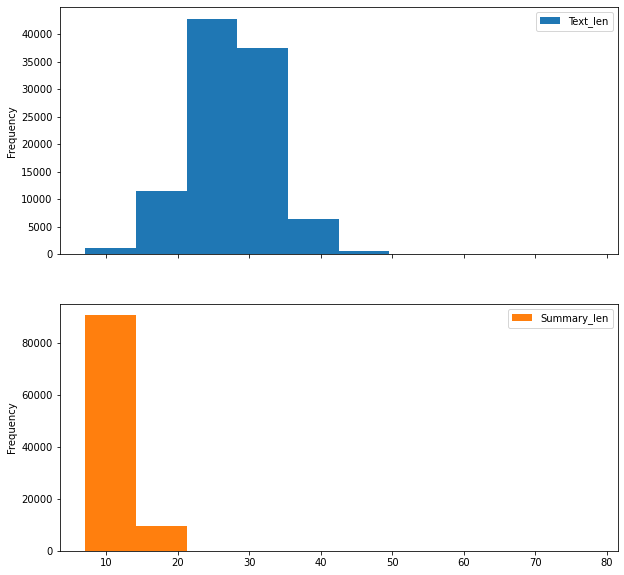

In [9]:
new_df.plot(kind='hist',subplots=True, figsize=(10,10))

max_text_len= new_df['Text_len'].max()
max_summary_len= new_df['Summary_len'].max()
# max_text_len= 40
# max_summary_len= 15

In [ ]:
w2v = Word2Vec(gen_text, min_count=1, size = 300, window=5,alpha=0.025, min_alpha=0.001, iter=10)
# w2v_summary = Word2Vec(gen_summary, min_count=1, size = 300, window=5,alpha=0.025, min_alpha=0.001, iter=10)

In [11]:
from keras.layers import Input,Embedding, LSTM, Dense, Concatenate, Activation, Bidirectional, Layer, TimeDistributed
from keras.models import Model, Sequential, load_model
import keras.backend as K
from keras.callbacks import EarlyStopping

In [12]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [13]:
x_tr,x_val,y_tr,y_val = train_test_split(np.array(new_df["Generalized Text"]),np.array(new_df["Summary"]),test_size=0.1, random_state=0,shuffle=True)

In [14]:
(x_tr[0],"\n",y_tr[0])

('united airlines may have hit on name for its new discount carrier ted but some analysts question whether the launching of the low cost carrier will help the ailing airline fortunes',
 '\n',
 'sostok _START_ analysts question ual strategy as ted prepares for takeoff _END_ eostok')

In [15]:
# x_tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(x_tr)

x_tr_seq= x_tokenizer.texts_to_sequences(x_tr)
x_val_seq= x_tokenizer.texts_to_sequences(x_val)

x_tr=pad_sequences(x_tr_seq, maxlen=max_text_len, padding='post')
x_val=pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc = len(x_tokenizer.word_index) + 1


In [16]:
# y_tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(y_tr)

y_tr_seq= y_tokenizer.texts_to_sequences(y_tr)
y_val_seq= y_tokenizer.texts_to_sequences(y_val)

y_tr=pad_sequences(y_tr_seq, maxlen=max_summary_len ,padding='post')
y_val=pad_sequences(y_val_seq, maxlen=max_summary_len ,padding='post')

y_voc = len(y_tokenizer.word_index) + 1


In [17]:
print(y_tokenizer.word_index)

{'end': 1, 'start': 2, 'sostok': 3, 'eostok': 4, 'to': 5, 'in': 6, 'of': 7, 'for': 8, 'on': 9, 'us': 10, 'unk': 11, 'percent': 12, 'as': 13, 'with': 14, 'at': 15, 'new': 16, 'over': 17, 'shares': 18, 'says': 19, 'after': 20, 'close': 21, 'up': 22, 'china': 23, 'and': 24, 'from': 25, 'un': 26, 'iraq': 27, 'world': 28, 'against': 29, 'the': 30, 'stocks': 31, 'talks': 32, 'eu': 33, 'south': 34, 'killed': 35, 'president': 36, 'two': 37, 'higher': 38, 'french': 39, 'first': 40, 'police': 41, 'lower': 42, 'kong': 43, 'hong': 44, 'out': 45, 'dollar': 46, 'india': 47, 'israeli': 48, 'oil': 49, 'down': 50, 'british': 51, 'minister': 52, 'cup': 53, 'government': 54, 'chief': 55, 'israel': 56, 'bank': 57, 'indian': 58, 'pakistan': 59, 'trade': 60, 'prices': 61, 'leader': 62, 'pm': 63, 'three': 64, 'calls': 65, 'peace': 66, 'russian': 67, 'german': 68, 'court': 69, 'bush': 70, 'dead': 71, 'visit': 72, 'russia': 73, 'france': 74, 'into': 75, 'australian': 76, 'open': 77, 'chinese': 78, 'off': 79, '

In [18]:
latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = Bidirectional(LSTM(latent_dim, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm1(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output1, state_h1, state_c1= encoder_lstm1(enc_emb)

# #encoder lstm 2
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# #encoder lstm 3
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
# decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=encoder_states)

# #dense layer
# decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
# decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 78)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 78, 200)      8176200     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 600),        1202400     ['embedding[0][0]']              
                                 (None, 300),                                                 

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [22]:
# , metrics
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
1407/1407 [==============================] - 159s 112ms/step - loss: 2.0355 - val_loss: 1.7035
Epoch 2/10
1407/1407 [==============================] - 139s 99ms/step - loss: 1.6010 - val_loss: 1.4868
Epoch 3/10
1407/1407 [==============================] - 138s 98ms/step - loss: 1.3703 - val_loss: 1.3679
Epoch 4/10
1407/1407 [==============================] - 137s 97ms/step - loss: 1.1935 - val_loss: 1.3044
Epoch 5/10
1407/1407 [==============================] - 137s 98ms/step - loss: 1.0420 - val_loss: 1.2736
Epoch 6/10
1407/1407 [==============================] - 138s 98ms/step - loss: 0.9091 - val_loss: 1.2651
Epoch 7/10
1407/1407 [==============================] - 137s 97ms/step - loss: 0.7952 - val_loss: 1.2696
Epoch 8/10
1407/1407 [==============================] - 137s 97ms/step - loss: 0.6997 - val_loss: 1.2835
Epoch 9/10
1407/1407 [==============================] - 137s 97ms/step - loss: 0.6175 - val_loss: 1.3001
Epoch 10/10
1407/1407 [==============================]

In [ ]:
model.save('TS_LSTM_model.h5')

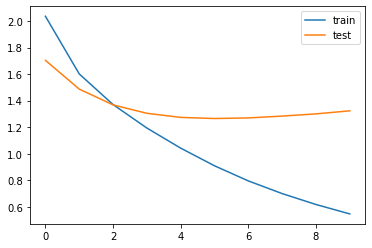

In [23]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [25]:
# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)
# define inference decoder
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs)

decoder_outputs, state_h, state_c = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)




# # Encode the input sequence to get the feature vector
# encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_output1, state_h1, state_c1])

# # Decoder setup
# # Below tensors will hold the states of the previous time step
# decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# # Get the embeddings of the decoder sequence
# dec_emb2= dec_emb_layer(decoder_inputs) 
# # To predict the next word in the sequence, set the initial states to the states from the previous time step
# decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# # A dense softmax layer to generate prob dist. over the target vocabulary
# decoder_outputs2 = decoder_dense(decoder_outputs2) 

# # Final decoder model
# decoder_model = Model(
#     [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
#     [decoder_outputs2] + [state_h2, state_c2])

In [26]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_word_index['sostok']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        states_value = [h, c]

    return decoded_sentence






def decode_sequence1(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [27]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [28]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: united airlines may have hit on name for its new discount carrier ted but some analysts question whether the launching of the low cost carrier will help the ailing airline fortunes 
Original summary: start analysts question ual strategy as ted prepares for takeoff end 
1/1 [==============================] - 0s 24ms/step
Predicted summary:  start air travel to cost new outlets in europe end


Review: india granted aid to senegal worth million unk for purchase of farm equipment under an agreement concluded by the two countries prime ministers on the sidelines of the summit meeting just held in harare 
Original summary: start india grants mn dollars in aid to senegal end 
1/1 [==============================] - 0s 24ms/step
Predicted summary:  start india gives million dollars in aid to cambodia end


Review: united nations forces in bosnia demanded thursday the immediate withdrawal of croat forces from the country 
Original summary: start un demands withdrawal of croat troops from